In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Give values to measured units
mV = 1e-3
nF = 1e-9
ms = 1e-3
nA = 1e-9

MOhm = 1e6

### Basic ring model 1
This is an LIF model synapsed like in a ring-attractor. The neurons are networked using a connectivity matrix that enforces symmetric weights, but of any magnitude. This allows a broad range of interactions between the neurons so long as they are required to be symmetric.

Note: By symmetric, we mean that neurons to the left and right of the focal neuron will have the same weights.

In [3]:
class LIFNeuron:
    def __init__(self, ID, C=1*nF, Ip=0*nA, V0=-60*mV, Vth=-48*mV, Vr=-80*mV, Vleak=-70*mV, tau_m=20*ms):
        '''Set the parameters of the LIF neuron'''
        self.id = ID                   # Neuron ID
        self.C = C
        self.Ip = Ip                   # Poisson input current
        self.I = 0.0                   # Total input current (poisson + synapses)
        self.Vth = Vth                 # Membrane potential threshold value
        self.Vr = Vr                   # Membrane potential reset value
        self.Vleak = Vleak             # Resting membrane potential / leaky reversal potential
        
        self.tau_m = tau_m             # Membrane time constant
        self.tau_ref = 2*ms
        self.tau_s_in = 5*ms
        self.tau_s_ex = 5*ms
        
        self.V = V0                    # Initial membrane potential
        self.synapses = {}             # {neuron ID : weight}

    def update(self):
        '''Updates the LIF neuron's state for a single time step'''
        self._hyperpolarize()
        self._updateCurrent()
        self._updatePotential()
        self._depolarize()

    def _updatePotential(self):
        '''Update LIF neuron's membrane potential'''
        V_L = self.V - self.Vleak
        Vtarget = -V_L + self.I*self.tau_m
        dV = (Vtarget/self.tau_m)*ms
        self.V += dV

    def _updateCurrent(self):
        '''Update current input to the LIF neuron'''
        self.I = 0.0
        self.I += self.Ip

        for neuron, weight in self.synapses.items():
            if neuron.V == 0.0:
                self.I += weight
                
    def _hyperpolarize(self):
        '''Set membrane potential to the reset value if an action potential has just been fired'''
        if self.V == 0.0:
            self.V = self.Vr

    def _depolarize(self):
        '''Set membrane potential to 0 if an action potential has been fired'''
        if self.V >= self.Vth:
            self.V = 0.0

In [4]:
def kth_diag_indices(a, k):
    '''Return indices of the elements on the k-th diagonal of array a'''
    rows, cols = np.diag_indices_from(a)
    if k < 0:
        return rows[-k:], cols[:k]
    elif k > 0:
        return rows[:-k], cols[k:]
    else:
        return rows, cols

def make_connectivity_matrix(weights, n):
    '''Make a connectivity matrix for all pairs in a network of n neurons'''
    connectivity_matrix = np.zeros((n,n))

    for i, w in enumerate(weights):
        connectivity_matrix[kth_diag_indices(connectivity_matrix, i)] = w
        connectivity_matrix[kth_diag_indices(connectivity_matrix, -i)] = w

    connectivity_matrix[connectivity_matrix < -1.0] = 0.0
    return connectivity_matrix

def connect_neurons(connectivity_matrix, neurons, n):
    '''Connect neurons of LIFNeuron class based on connectivity matrix cv'''
    for row in range(n):
        for col in range(row,n):

            # We don't want neurons connected to themselves
            if row == col:
                continue
            
            neurons[row].synapses[neurons[col]] = connectivity_matrix[row, col]
            neurons[col].synapses[neurons[row]] = connectivity_matrix[col, row]

In [5]:
# Number of neurons in the network
n = 16

# Create an instance of the LIFNeuron class
lif_neurons = [LIFNeuron(ID) for ID in range(n)]

# Set the time step and the time range
t = np.arange(0, 1, ms)

# Connect neurons with ring-attractor type weights
weights = np.linspace(1, -1.2, n)
connectivity_matrix = make_connectivity_matrix(weights, n)
connect_neurons(connectivity_matrix, lif_neurons, n)

# Input current received by specific neurons
poissonInput = np.random.poisson(lam=1.0, size=len(t))
poissonWeight = 1.0
poissonConnections = [4,5,6,7,8]

potentials = [[] for _ in range(n)]

# Iterate over the time range
for idx,t_ in enumerate(t):
    for neuron in lif_neurons:

        if t_ < 200*ms:
            if neuron.id in poissonConnections:
                neuron.Ip = poissonInput[idx] * poissonWeight
        else:
            if neuron.id in poissonConnections:
                neuron.Ip = 0
            

        neuron.update()

        potentials[neuron.id].append(neuron.V)

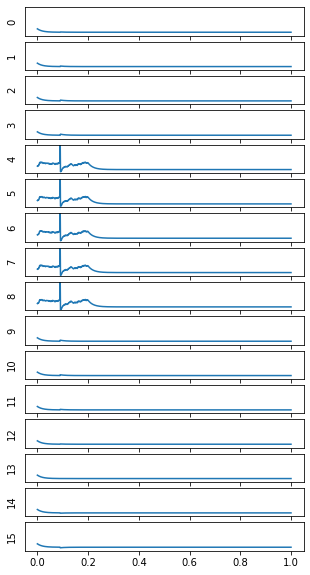

In [6]:
# Plot memebrane potentials of all neurons over time 
fig,axes = plt.subplots(n,1, figsize=(5,10), sharex=True)

for i, ax in enumerate(axes):
    ax.plot(t,potentials[i])
    ax.set_ylabel(i)
    ax.set_ylim(-0.08,0)
    ax.set_yticklabels([])
    ax.set_yticks([])

plt.show()

### Basic ring model 2
This is a second implementation of the ring-attractor model. Here, the weights between neighbouring neurons are hard coded such that all neurons excite two neurons on either side with a weight of +1 and inhibit the subsequent 3 neurons wiht a weight of -1. All other neurons are unaffected by the focal neuron.

In [7]:
class LIFNeuron:
    def __init__(self, ID, C=1*nF, V0=-60*mV, Vth=-48*mV, Vr=-80*mV, Vleak=-70*mV, 
                 Vsyn_ex=0*mV, Vsyn_in=-70*mV, tau_m=20*ms):
        # Set the parameters of the LIF neuron
        self.id = ID
        self.I_ext = 0.0                              # External current
        self.C = C                                    # Membrane capacitance
        self.Vth = Vth                                # Membrane potential threshold value
        self.Vr = Vr                                  # Membrane potential reset value
        self.Vleak = Vleak                            # Resting membrane potential / leaky reversal potential
        self.Vsyn_ex = Vsyn_ex                        # Excitatory synaptic reversal potential
        self.Vsyn_in = Vsyn_in                        # Inhibitory synaptic reversal potential
        
        self.tau_m = tau_m                            # Membrane time constant
        self.tau_ref = 2*ms                           # Refractory period
        self.tau_s_ex = 5*ms                          # Excitatory synaptic time constant
        self.tau_s_in = 5*ms                          # Inhibitory synaptic time constant
        
        self.V = Vr                                   # Initial membrane potential
        self.dt = 1*ms
        self.t_last_spike = 1000*ms                   # Time since last spike
        self.k_ex = 1 / (self.tau_s_ex * np.exp(-1))  # Maximum conductance of an excitatory synapse
        self.k_in = 1 / (self.tau_s_in * np.exp(-1))  # Maximum conductance of an inhibitory synapse
        
        self.synapses = {}                            # Outgoing synapses {neuron ID : weight}
        
        # exc and inh pre-synaptic time delays from last spike, [(time_delay, weight), (...)]
        self.in_ps_td = []
        self.ex_ps_td = []
    
    def update(self):
        '''Updates the LIF neuron's state for a single time step'''
        if self.V == 0.0:
            self._hyperpolarize()
        elif self.V >= self.Vth:
            self._depolarize()
        else:
            self._updatePotential()
            
        # Send time delays to connected neurons
        for neuron,weight in self.synapses.items():
            if weight < 0:
                neuron.in_ps_td.append((self.t_last_spike, weight))
            if weight > 0:
                neuron.ex_ps_td.append((self.t_last_spike, weight))
        
        self.t_last_spike += self.dt
        
        self.in_ps_td.clear()
        self.ex_ps_td.clear()
    
    def _updatePotential(self):
        '''Update LIF neuron's membrane potential'''
        dV = (-self.I_L() - self.I_S_ex() - self.I_S_in() + self.I_ext) / self.C * self.dt
        self.V += dV
    
    def I_L(self):
        '''Return leak current'''
        return self.C/self.tau_m * (self.V - self.Vleak)

    def I_S_ex(self):
        '''Return synaptic current received from an excitatory synpase'''
        I_s = 0
        if self.t_last_spike > self.tau_ref:
            for td, w in self.ex_ps_td:
                Is = self._gEx(td) * (self.V - self.Vsyn_ex)
                Is *= w
                I_s += Is

        return I_s
    
    def I_S_in(self):
        '''Return synaptic current received from an inhibitory synpase'''
        I_s = 0
        if self.t_last_spike > self.tau_ref:
            for td, w in self.in_ps_td:
                Is = self._gIn(td) * (self.V - self.Vsyn_in)
                Is *= w
                I_s += Is

        return I_s
    
    def _gEx(self, t):
        '''Return conductance of an excitatory synapse'''
        return self.k_ex * t * np.exp(-t/self.tau_s_ex)

    def _gIn(self, t):
        '''Return conductance of an inhibitory synapse'''
        return self.k_in * t * np.exp(-t/self.tau_s_in)
    
    def _hyperpolarize(self):
        '''Set membrane potential to the reset value if an action potential has just been fired'''
        self.V = self.Vr

    def _depolarize(self):
        '''Set membrane potential to 0 if an action potential has been fired'''
        self.V = 0.0
        self.receiveActionPotential()
            
    def receiveActionPotential(self):
        '''Reset time since the last spike to 0 once an action potential has been fired'''
        self.t_last_spike = 0*ms

In [8]:
# Number of neurons in the network
n = 32

# Create an instance of the LIFNeuron class
lif_neurons = [LIFNeuron(ID) for ID in range(n)]

# Set the time step and the time range
t = np.arange(0, 1, ms)

# Connect neurons with ring-attractor type weights
for neur in lif_neurons:
    # All neurons excite other neurons that are within a range of 2 from them
    for i in range(1, 3):
        neur.synapses[lif_neurons[(neur.id + i) % n]] = 1
        neur.synapses[lif_neurons[neur.id - i]] = 1

    # All neurons inhibit other neurons that are 3 to 6 spaces away from them
    for i in range(3, 7):
        neur.synapses[lif_neurons[(neur.id + i) % n]] = -1
        neur.synapses[lif_neurons[neur.id - i]] = -1

potentials = [[] for _ in range(n)]

# Iterate over the time range
for t_ in t:
    for neuron in lif_neurons:
        if neuron.id == 0:
            if t_ < 200*ms:
                neuron.I_ext = 1.5 * 1e-9
            if t_ > 200*ms:
                neuron.I_ext = 0

        neuron.update()

        potentials[neuron.id].append(neuron.V)

/var/folders/ng/l4j590g95vl5r33ctw59y6cr0000gn/T/ipykernel_42147/2477277748.py:54: RuntimeWarning: overflow encountered in double_scalars
  dV = (-self.I_L() - self.I_S_ex() - self.I_S_in() + self.I_ext) / self.C * self.dt
/var/folders/ng/l4j590g95vl5r33ctw59y6cr0000gn/T/ipykernel_42147/2477277748.py:77: RuntimeWarning: invalid value encountered in double_scalars
  Is = self._gIn(td) * (self.V - self.Vsyn_in)
/var/folders/ng/l4j590g95vl5r33ctw59y6cr0000gn/T/ipykernel_42147/2477277748.py:54: RuntimeWarning: invalid value encountered in double_scalars
  dV = (-self.I_L() - self.I_S_ex() - self.I_S_in() + self.I_ext) / self.C * self.dt
/var/folders/ng/l4j590g95vl5r33ctw59y6cr0000gn/T/ipykernel_42147/2477277748.py:66: RuntimeWarning: invalid value encountered in double_scalars
  Is = self._gEx(td) * (self.V - self.Vsyn_ex)


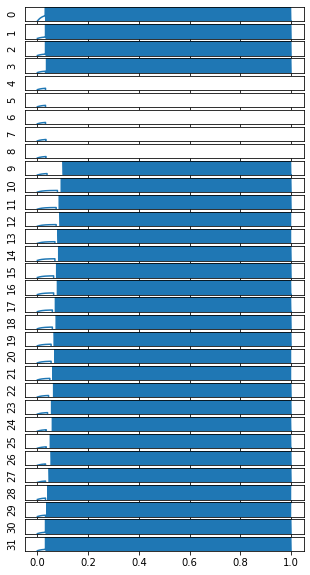

In [9]:
# Plot memebrane potentials of all neurons over time 
fig,axes = plt.subplots(n,1, figsize=(5,10), sharex=True)

for i, ax in enumerate(axes):
    ax.plot(t,potentials[i])
    ax.set_ylabel(i)
    ax.set_ylim(-0.08,0)
    ax.set_yticklabels([])
    ax.set_yticks([])

plt.show()

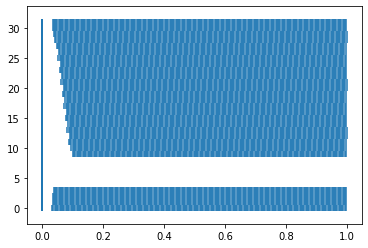

In [10]:
df = pd.DataFrame(potentials)
spikes = (df == 0.0).astype(int) * t
plt.eventplot(np.array(spikes))
plt.show()

We find that while a basic ring type structure seems implemented here, the neurons overflow and values of the membrane potential shoot up drastically. We will try and remedy this in our next implementation.